In [22]:
import os
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

First, analyze the aggregate results

In [23]:
results_dir = os.path.abspath('./pytorch_results')
results_df = None
columns = ['imp', 'dataset', 'metric', 'fold', 'score', 'signal', 'seed']

for signal in ['signal', 'shuffled']:
    for seed in range(1, 6):
        parsed_result = {c: [] for c in columns}
        cv_results_file = os.path.join(results_dir,
                                       'cv_results_{}_{}.pkl'.format(signal, seed))
        with open(cv_results_file, 'rb') as f:
            cv_results = pkl.load(f)
        num_folds = len(list(cv_results.values())[0])
        for fold in range(num_folds):
            for k, vs in cv_results.items():
                imp, dataset, metric = k.split('_')
                parsed_result['imp'].append(imp)
                parsed_result['dataset'].append(dataset)
                parsed_result['metric'].append(metric)
                parsed_result['fold'].append(fold)
                parsed_result['score'].append(vs[fold])
                parsed_result['signal'].append(signal)
                parsed_result['seed'].append(seed)
        df = pd.DataFrame(parsed_result)
        if results_df is None:
            results_df = df
        else:
            results_df = pd.concat((results_df, df))

results_df.head(n=5)

,imp,dataset,metric,fold,score,signal,seed
0,sklearn,train,auroc,0,0.933707,signal,1
1,sklearn,train,aupr,0,0.907813,signal,1
2,sklearn,train,acc,0,0.876049,signal,1
3,sklearn,tune,auroc,0,0.913121,signal,1
4,sklearn,tune,aupr,0,0.875318,signal,1


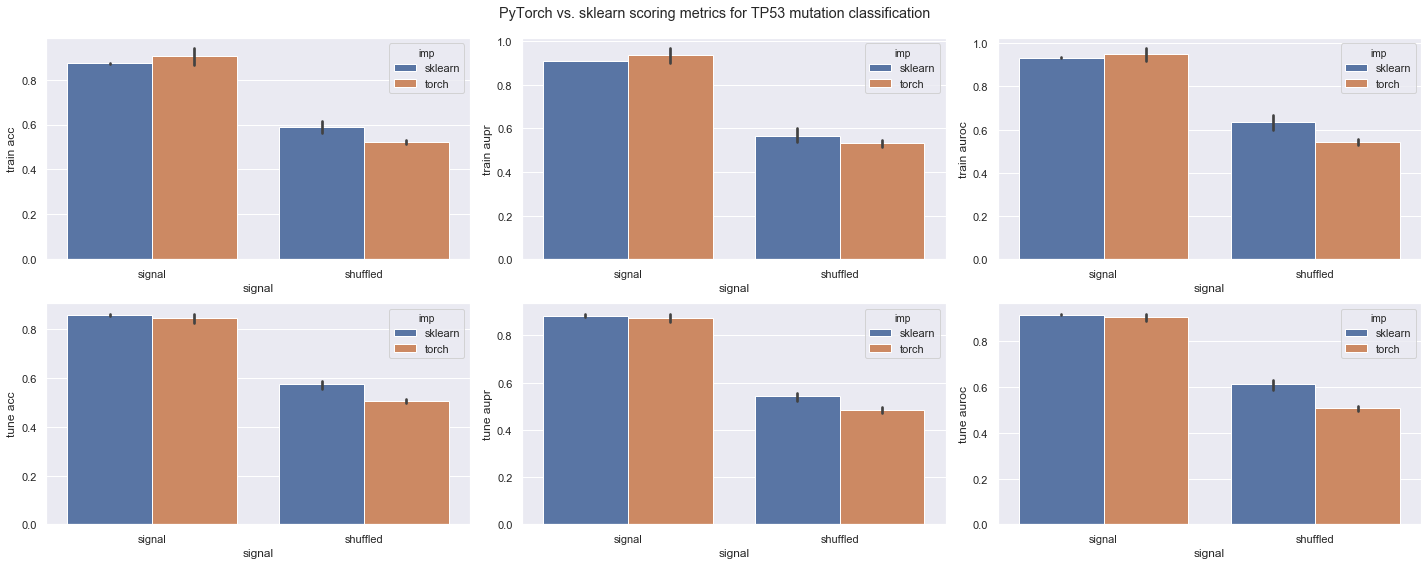

In [44]:
metrics = np.unique(results_df['metric'].values)
datasets = np.unique(results_df['dataset'].values)
sns.set()
fig, axarr = plt.subplots(len(datasets), len(metrics))
fig.set_figheight(8)
fig.set_figwidth(20)

for i, dataset in enumerate(datasets):
    for j, metric in enumerate(metrics):
        ax = axarr[i, j]
        plot_df = results_df[(results_df['metric'] == metric) & (results_df['dataset'] == dataset)]
        sns.barplot(data=plot_df, x='signal', y='score', hue='imp', ax=ax)
        ax.set_ylabel('{} {}'.format(dataset, metric))
plt.tight_layout()
fig.suptitle('PyTorch vs. sklearn scoring metrics for TP53 mutation classification')
fig.subplots_adjust(top=0.925)

Compare coefficients (sparsity and SVCCA)

In [31]:
from scipy.stats import pearsonr, spearmanr

columns = ['imp', 'signal', 'seed', 'fold', 'sparsity']
sparsity = []
for signal in ['signal', 'shuffled']:
    for seed in range(1, 6):
        sk_coefs_file = os.path.join(results_dir,
                                     'sklearn_coefs_{}_{}.tsv.gz'.format(
                                       signal, seed))
        sk_coefs_df = pd.read_csv(sk_coefs_file, sep='\t').sort_values('feature')
        torch_coefs_file = os.path.join(results_dir,
                                        'torch_coefs_{}_{}.tsv.gz'.format(
                                          signal, seed))
        torch_coefs_df = pd.read_csv(torch_coefs_file, sep='\t').sort_values('feature')
        folds = np.unique(sk_coefs_df['fold'].values)
        for fold in folds:
            sk_coefs = sk_coefs_df[sk_coefs_df['fold'] == fold]['weight'].values
            torch_coefs = torch_coefs_df[torch_coefs_df['fold'] == fold]['weight'].values
            sk_sparsity = np.count_nonzero(sk_coefs==0) / sk_coefs.shape[0]
            torch_sparsity = np.count_nonzero(torch_coefs==0) / torch_coefs.shape[0]
            sparsity.append(['sklearn', signal, seed, fold, sk_sparsity])
            sparsity.append(['torch', signal, seed, fold, torch_sparsity])
            
sparsity_df = pd.DataFrame(sparsity, columns=columns)
sparsity_df.head()

,imp,signal,seed,fold,sparsity
0,sklearn,signal,1,1,0.973822
1,torch,signal,1,1,0.000000
2,sklearn,signal,1,2,0.977063
3,torch,signal,1,2,0.000000
4,sklearn,signal,1,3,0.974944


Text(0.5, 1.0, 'Coefficient sparsity for PyTorch vs sklearn')

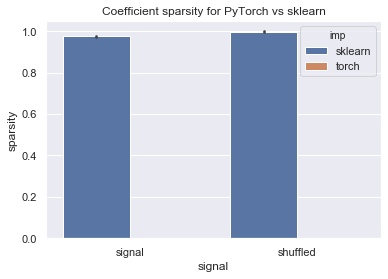

In [45]:
sns.set()
sns.barplot(data=sparsity_df, x='signal', y='sparsity', hue='imp')
plt.title('Coefficient sparsity for PyTorch vs sklearn')

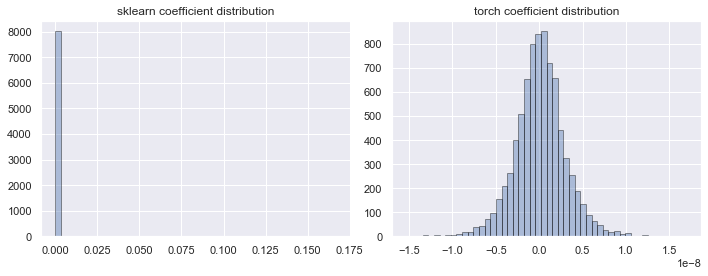

In [39]:
sns.set()
fig, axarr = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.set_figheight(4)
for i, coefs in enumerate([sk_coefs, torch_coefs]):
    ax = axarr[i]
    sns.distplot(coefs, kde=False, hist_kws={'edgecolor': 'black'}, ax=ax)
    ax.set_title('{} coefficient distribution'.format('sklearn' if i==0 else 'torch'))
plt.tight_layout()